### Instalación de Librerías

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

In [6]:
pip install gap-stat==2.0.2

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install statsmodels

In [13]:
pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   --------------------------------------- 920.8/920.8 kB 43.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install plotnine

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 16.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Carga de Librerías y Funciones Auxiliares


In [22]:
# Manejo de datos
import numpy as np  
import pandas as pd 
from itertools import combinations

# Visualización
import matplotlib.pyplot as plt  # Creación de gráficos
import seaborn as sns

# Machine Learning (Clustering)

from sklearn.cluster import KMeans 
import skfuzzy as fuzzy
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler  # Normalización de datos
from sklearn.metrics import silhouette_score  # Evaluación de calidad del clustering
from scipy.stats import spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Análisis avanzado de clusters
from gap_statistic import OptimalK  # Selección del número óptimo de clusters (Gap Statistic)


# Sistema de archivos
import os 

#1. Funciones exploratorias
def informacion_general(df, umbral_categoricas):
    """
    Función para obtener información general de un DataFrame:
    - Número de filas y columnas.
    - Clasificación de variables en listas según su tipo (numéricas, categóricas, fechas, etc.).
    - Identifica variables numéricas con un número limitado de valores como categóricas especiales.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        umbral_categoricas (int): Número máximo de valores únicos para considerar una variable numérica como categórica especial.

    Returns:
        dict: Diccionario con las listas de variables numéricas, categóricas, fechas, categóricas especiales, y otras.
    """
    # Número de filas y columnas
    print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.\n")
    
    # Inicializar listas para clasificar las variables
    variables_categoricas = []
    variables_numericas = []
    variables_fecha = []
    variables_otros = []
    variables_categoricas_especiales = []
    
    # Clasificación de las variables según su tipo
    for col in df.columns:
        unique_values = df[col].nunique()  # Contar valores únicos
        if pd.api.types.is_numeric_dtype(df[col]):
            # Verificar si la variable numérica tiene pocos valores únicos
            if unique_values <= umbral_categoricas:
                variables_categoricas_especiales.append(col)
            else:
                variables_numericas.append(col)
        elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:
            variables_categoricas.append(col)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            variables_fecha.append(col)
        else:
            variables_otros.append(col)
    
    # Imprimir las listas
    print(f"Variables numéricas: {variables_numericas}\n")
    print(f"Variables categóricas: {variables_categoricas}\n")
    print(f"Variables de tipo fecha: {variables_fecha}\n")
    print(f"Variables categóricas especiales (<= {umbral_categoricas} valores únicos): {variables_categoricas_especiales}\n")
    print(f"Variables de otros tipos: {variables_otros}\n")
    
    # Retornar las listas en un diccionario
    return {
        "numericas": variables_numericas,
        "categoricas": variables_categoricas,
        "fechas": variables_fecha,
        "categoricas_especiales": variables_categoricas_especiales,
        "otros": variables_otros
    }


#2. Función para ver la calidad de los datos
def calidad_datos(df, listas_variables, iqr_factor = 5):
    """
    Función para analizar la calidad de los datos:
    - Identifica valores nulos por tipo de variable (numéricas, categóricas, fechas, etc.).
    - Detecta duplicados en el DataFrame completo.
    - Detecta posibles errores.
    - Encuentra outliers usando el método IQR (Interquartile Range) e incluye explicaciones.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        listas_variables (dict): Diccionario con listas de variables clasificadas (numéricas, categóricas, etc.).
        iqr_factor (float): Factor para determinar outliers usando el rango intercuartílico.

    Returns:
        dict: Resumen de la calidad de los datos, incluyendo valores nulos, duplicados, posibles errores y outliers.
    """
    resumen = {}

    # Valores nulos
    print("Análisis de valores nulos:")
    nulos = df.isnull().sum()
    total_filas = len(df)
    porcentaje_nulos = (nulos / total_filas) * 100

    print("\nValores nulos por tipo de variable:")
    for tipo, lista in listas_variables.items():
        if lista:
            nulos_tipo = nulos[lista]
            porcentaje_tipo = porcentaje_nulos[lista]
            print(f"\nTipo: {tipo}")
            print(pd.DataFrame({"Valores Nulos": nulos_tipo, "% Nulos": porcentaje_tipo}).sort_values("% Nulos", ascending=False))
    
    resumen["valores_nulos"] = nulos

    # Duplicados
    print("\nAnálisis de duplicados:")
    duplicados = df.duplicated().sum()
    print(f"Registros duplicados: {duplicados} ({(duplicados / total_filas) * 100:.2f}%)")
    resumen["duplicados"] = duplicados

    # Posibles errores
    print("\nAnálisis de posibles errores:")
    errores = {}

    # Errores en variables categóricas (categorías mal etiquetadas)
    if "categoricas" in listas_variables:
        for col in listas_variables["categoricas"]:
            valores_unicos = df[col].unique()
            print(f"Columna categórica: {col} - Valores únicos: {valores_unicos}")
            errores[col] = {"valores_unicos": valores_unicos}

    # Errores en variables numéricas (valores fuera de rango)
    if "numericas" in listas_variables:
        for col in listas_variables["numericas"]:
            minimo = df[col].min()
            maximo = df[col].max()
            print(f"Columna numérica: {col} - Rango: [{minimo}, {maximo}]")
            errores[col] = {"min": minimo, "max": maximo}
    
    resumen["posibles_errores"] = errores

    # Detección de outliers con IQR
    print("\nAnálisis de outliers (Método IQR):")
    outliers = {}
    if "numericas" in listas_variables:
        for col in listas_variables["numericas"]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - iqr_factor * IQR
            limite_superior = Q3 + iqr_factor * IQR

            # Identificar índices de outliers
            outliers_indices = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].index
            outliers_values = df.loc[outliers_indices, col]
            if not outliers_values.empty:  # Solo imprimir si hay outliers
                outliers[col] = {
                    "outliers": len(outliers_indices),
                    "indices": outliers_indices.tolist(),
                    "limites": (limite_inferior, limite_superior),
                    "min_outlier": outliers_values.min(),
                    "max_outlier": outliers_values.max(),
                }

                # Mensaje explicativo
                print(
                    f"Columna {col}: Se detectaron {len(outliers_indices)} valores fuera de los límites definidos "
                    f"por los cuantiles.\n"
                    f"- Límite inferior: {limite_inferior}\n"
                    f"- Límite superior: {limite_superior}\n"
                    f"Estos valores se consideran outliers porque están fuera del rango intercuartílico "
                    f"({iqr_factor} veces el IQR).\n"
                    f"- El mínimo registro considerado como outlier es: {outliers[col]['min_outlier']}\n"
                    f"- El máximo registro considerado como outlier es: {outliers[col]['max_outlier']}\n"
                )
    
    resumen["outliers"] = outliers

    return resumen

def relaciones_entre_variables(df, listas_variables, max_categorias=10):
    """
    Analiza las relaciones entre variables en un DataFrame.
    - Relaciones lineales: Correlación de Pearson entre variables numéricas.
    - Relaciones no lineales: Correlación de Spearman entre variables numéricas.
    - Relaciones con variables categóricas: Proporción de varianza explicada (Eta Squared).

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        listas_variables (dict): Diccionario con listas de variables clasificadas (numéricas, categóricas, etc.).
        max_categorias (int): Número máximo de categorías para analizar relaciones categóricas.

    Returns:
        dict: Diccionario con los resultados de las relaciones encontradas.
    """
    resultados = {
        "relaciones_lineales": [],
        "relaciones_no_lineales": [],
        "relaciones_categoricas": []
    }

    # 1. Relaciones Lineales (Correlación de Pearson)
    if "numericas" in listas_variables and len(listas_variables["numericas"]) > 1:
        correlaciones = df[listas_variables["numericas"]].corr()

        # Mapa de calor
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Mapa de Calor de Correlaciones (Pearson)")
        plt.show()

        # Top 3 relaciones lineales más fuertes
        corr_pairs = (
            correlaciones.abs()
            .unstack()
            .drop_duplicates()
            .sort_values(ascending=False)
        )
        top_3_corr = corr_pairs[corr_pairs < 1].head(3)  # Excluir autocorrelaciones
        for idx, value in top_3_corr.items():
            resultados["relaciones_lineales"].append({"variables": idx, "correlacion": value})

    # 2. Relaciones No Lineales (Correlación de Spearman)
    if "numericas" in listas_variables and len(listas_variables["numericas"]) > 1:
        spearman_results = []
        for var1, var2 in combinations(listas_variables["numericas"], 2):
            corr, _ = spearmanr(df[var1], df[var2])
            spearman_results.append((var1, var2, abs(corr)))

        # Ordenar por la relación más fuerte
        spearman_results.sort(key=lambda x: -x[2])
        top_3_spearman = spearman_results[:3]
        for var1, var2, corr in top_3_spearman:
            resultados["relaciones_no_lineales"].append({"variables": (var1, var2), "correlacion": corr})

    # 3. Relaciones con Variables Categóricas
    if "categoricas" in listas_variables and "numericas" in listas_variables:
        cat_num_relations = []
        for cat in listas_variables["categoricas"]:
            # Filtrar variables categóricas con un número razonable de categorías
            if df[cat].nunique() <= max_categorias:
                for num in listas_variables["numericas"]:
                    modelo = smf.ols(f"{num} ~ C({cat})", data=df).fit()
                    anova_tabla = sm.stats.anova_lm(modelo, typ=2)
                    eta_squared = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
                    cat_num_relations.append((cat, num, eta_squared))

        # Top 3 relaciones categóricas-numéricas más significativas
        cat_num_relations.sort(key=lambda x: -x[2])
        top_3_categoricas = cat_num_relations[:3]
        for cat, num, eta in top_3_categoricas:
            resultados["relaciones_categoricas"].append({"categoria": cat, "numerica": num, "eta_squared": eta})

    return resultados



### Análisis Exploratorio de los datos

In [1145]:
#Ver los archivos que tenemos en el repositorio creado para la Evaluación I
ruta_input = "C:/Users/Fernando_Fuentes/OneDrive/UAI/Curso Riesgo/Clase 4/Evaluacion 1/"
archivos = os.listdir(ruta_input)
print(archivos)

['.csv', '.ipynb_checkpoints', 'Analisis Datos.ipynb', 'caso segmentacion.xlsx', 'caso segmentacion_old.xlsx', 'Data Mining with Python.pdf', 'data.csv', 'Evaluacion_I.ipynb', 'Evaluacion__orig.ipynb', 'Preguntas.docx', 'your_file_name.csv']


In [1147]:
#Ver el nombre de las hojas del Excel
excel_file = pd.ExcelFile(ruta_input + "caso segmentacion.xlsx")
print("Hojas disponibles en el archivo:")
print(excel_file.sheet_names)

Hojas disponibles en el archivo:
['dictionary', 'data']


In [1149]:
#Hoja de Diccionario
diccionario_datos = pd.read_excel(ruta_input + "caso segmentacion.xlsx", sheet_name = "dictionary")

#Hoja de Datos
datos_cobranza = pd.read_excel(ruta_input + "caso segmentacion.xlsx", sheet_name = "data")

In [1150]:
diccionario_datos

,Features,Definition,Additional Note
0,KEY_784,bureau score,NaN
1,KEY_858,Orion key,Internal risk score using BNS customers' depos...
2,KEY_857,Bureau WORST_DELQ_L12M,NaN
3,KEY_781,worst delinquency in last 12 months in the fin...,NaN
4,KEY_909,Number of times 2 CPD L12M (All RV/LN/MG accou...,NaN
5,KEY_417,worst delinquent L12M - all products,NaN
6,KEY_808,Number of trades with 30 days+ delinquency in ...,NaN
7,KEY_924,hedy score,Internal risk score to evaluting if we should ...
8,KEY_802,Number of Trades with 60 days+ delinquency in ...,NaN
9,KEY_908,Number of times 1 CPD L12M (All RV/LN/MG accou...,NaN


In [1151]:
# Eliminar espacios al inicio y final de los nombres de las columnas
datos_cobranza.columns = datos_cobranza.columns.str.strip()

# Opcional: Reemplazar espacios internos con guiones bajos
datos_cobranza.columns = datos_cobranza.columns.str.replace(' ', '_')

In [1152]:

    """
    Cleans the 'KEY_784_MOD' column in the provided DataFrame based on conditions
    applied to 'KEY_784' and 'KEY_406'.

    Args:
    datos_cobranza (pd.DataFrame): The DataFrame containing the data to be cleaned.

    Returns:
    pd.Series: The modified 'KEY_784_MOD' column.
    """
    # Condiciones para completar datos perdidos em Score Bureau
    condition_key_784 = datos_cobranza['KEY_784'].isin([0, 1])
    condition_key_406 = ~datos_cobranza['KEY_406'].isin([0, 1])
    condition_cyc_dlq_43_01= datos_cobranza['cyc_dlq_43_01'].isin([0])
    condition_cyc_dlq_43_02= datos_cobranza['cyc_dlq_43_02'].isin([0])
    condition_cyc_dlq_43_03= datos_cobranza['cyc_dlq_43_03'].isin([0])
    condition_cyc_dlq_43_04= datos_cobranza['cyc_dlq_43_04'].isin([0])
    condition_cyc_dlq_43_05= datos_cobranza['cyc_dlq_43_05'].isin([0])
    condition_cyc_dlq_43_06= datos_cobranza['cyc_dlq_43_06'].isin([0])
    condition_KEY_808= datos_cobranza['KEY_808'].isin([0])
  
   
# Nvo score aplicando las condiciones para los casos con 0 y 1
    datos_cobranza['KEY_784_MOD'] = np.where(
        condition_key_784,
        np.where(condition_key_406, datos_cobranza['KEY_406'], datos_cobranza['KEY_924']),
        datos_cobranza['KEY_784'])

condition_KEY_784_MOD = datos_cobranza['KEY_784_MOD'].isin([0, 1]) 

# actualizo ultimos casos con media para las condiciones dadas (7 casos)
datos_cobranza.loc[condition_KEY_784_MOD & (datos_cobranza['cyc_dlq_43_01']==0 ),'KEY_784_MOD'] =779

datos_cobranza.loc[(datos_cobranza['KEY_784_MOD'].isin([0, 1])) & (datos_cobranza['cyc_dlq_43_01']>0 ),'KEY_784_MOD'] =690

#elimino resto de columnas de score KEY_784	KEY_924	KEY_406

datos_cobranza = datos_cobranza.drop ('KEY_784', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_924', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_406', axis = 1)


# elimino columnas correlacionadas con el score KEY_784_MOD: KEY_908 KEY_909 KEY_910 KEY_548 KEY_802 KEY_808
datos_cobranza = datos_cobranza.drop ('KEY_908', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_909', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_910', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_548', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_802', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_808', axis = 1)

# elimino columnas correlacionadas con el score KEY_803 por no aportar valor ya la deuda del sistema en su gran mayoria no supera la deuda morosa
datos_cobranza = datos_cobranza.drop ('KEY_803', axis = 1)

#actualizo dato missing de KEY_520 --> 9999999 
datos_cobranza.loc[datos_cobranza['KEY_520']==9999999 ,'KEY_520'] =0



#crear variables CPD - cyc_dlq_43_01 - cyc_dlq_43_02 -cyc_dlq_43_03

datos_cobranza['CPD_MOD']=np.where((datos_cobranza['CPD']==2),0.154,np.where((datos_cobranza['CPD']==3),0.231,0.308))
datos_cobranza['cyc_dlq_43_01_MOD']=np.where((datos_cobranza['cyc_dlq_43_01']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_01']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_02_MOD']=np.where((datos_cobranza['cyc_dlq_43_02']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_02']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_03_MOD']=np.where((datos_cobranza['cyc_dlq_43_03']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_03']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_01_dist']=datos_cobranza['cyc_dlq_43_01_MOD']-datos_cobranza['CPD_MOD']
datos_cobranza['cyc_dlq_43_02_dist']=datos_cobranza['cyc_dlq_43_02_MOD']-datos_cobranza['CPD_MOD']
datos_cobranza['cyc_dlq_43_03_dist']=datos_cobranza['cyc_dlq_43_03_MOD']-datos_cobranza['CPD_MOD']

#creo variable de distancia mora vs sistema completando missing values
datos_cobranza['KEY_781_MOD'] = np.where(
        (datos_cobranza['KEY_781']==99 ),
        datos_cobranza['KEY_417']-1, datos_cobranza['KEY_781'])

datos_cobranza['KEY_781_TRF']=np.where((datos_cobranza['KEY_781_MOD']==1),0.154,
                                     np.where((datos_cobranza['KEY_781_MOD']==2),0.231,
                                     np.where((datos_cobranza['KEY_781_MOD']==3),0.308,
                                     np.where((datos_cobranza['KEY_781_MOD']==4),0.385,
                                     np.where((datos_cobranza['KEY_781_MOD']==5),0.462,
                                     np.where((datos_cobranza['KEY_781_MOD']==6),0.538,
                                     np.where((datos_cobranza['KEY_781_MOD']==7),0.615,
                                     np.where((datos_cobranza['KEY_781_MOD']==8),0.692,
                                     np.where((datos_cobranza['KEY_781_MOD']==9),0.769,
                                     np.where((datos_cobranza['KEY_781_MOD']==10),0.846,
                                      np.where((datos_cobranza['KEY_781_MOD']==11),0.923,
                                              0.77)))))))))))

datos_cobranza['KEY_781_TRF_dist']=datos_cobranza['KEY_781_TRF']-datos_cobranza['CPD_MOD']


#ELIMINAR COLUMNAS CORRELACIONADAS
#datos_cobranza = datos_cobranza.drop ('cyc_dlq_43_01_dist', axis = 1)
#datos_cobranza = datos_cobranza.drop ('cyc_dlq_43_02_dist', axis = 1)
#datos_cobranza = datos_cobranza.drop ('cyc_dlq_43_03_dist', axis = 1)
#datos_cobranza = datos_cobranza.drop ('KEY_781_TRF_dist', axis = 1)


 

In [1157]:
#pd.options.display.max_columns=None

In [1159]:
#datos_cobranza.to_csv('your_file_name.csv', index=False)

In [1161]:
#datos_cobranza.info()

In [1163]:
#Si no tiene más de 10 registros distintos se considerará categorica (esto aplica para las var númericas).
listas_variables = informacion_general(datos_cobranza, umbral_categoricas=10)

El DataFrame tiene 6564 filas y 32 columnas.

Variables numéricas: ['Delinquent_balance', 'KEY_520', 'KEY_530', 'KEY_531', 'KEY_784_MOD', 'cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist', 'KEY_781_TRF_dist']

Variables categóricas: ['final_affluent_flag', 'LMT_flag']

Variables de tipo fecha: ['Business_date']

Variables categóricas especiales (<= 10 valores únicos): ['CPD', 'cyc_dlq_43_01', 'cyc_dlq_43_02', 'cyc_dlq_43_03', 'cyc_dlq_43_04', 'cyc_dlq_43_05', 'cyc_dlq_43_06', 'KEY_858', 'KEY_857', 'KEY_781', 'KEY_417', 'KEY_325', 'KEY_326', 'KEY_522', 'CPD_MOD', 'cyc_dlq_43_01_MOD', 'cyc_dlq_43_02_MOD', 'cyc_dlq_43_03_MOD', 'KEY_781_MOD', 'KEY_781_TRF']

Variables de otros tipos: []



C:\Users\Fernando_Fuentes\AppData\Local\Temp\ipykernel_84888\3330844189.py:64: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


In [1165]:
resumen_calidad = calidad_datos(datos_cobranza, listas_variables, iqr_factor=5)

Análisis de valores nulos:

Valores nulos por tipo de variable:

Tipo: numericas
                    Valores Nulos  % Nulos
Delinquent_balance              0      0.0
KEY_520                         0      0.0
KEY_530                         0      0.0
KEY_531                         0      0.0
KEY_784_MOD                     0      0.0
cyc_dlq_43_01_dist              0      0.0
cyc_dlq_43_02_dist              0      0.0
cyc_dlq_43_03_dist              0      0.0
KEY_781_TRF_dist                0      0.0

Tipo: categoricas
                     Valores Nulos  % Nulos
final_affluent_flag              0      0.0
LMT_flag                         0      0.0

Tipo: fechas
               Valores Nulos  % Nulos
Business_date              0      0.0

Tipo: categoricas_especiales
                   Valores Nulos  % Nulos
CPD                            0      0.0
cyc_dlq_43_01                  0      0.0
KEY_781_MOD                    0      0.0
cyc_dlq_43_03_MOD              0      0.0
cyc_dlq_

In [1167]:
#forzar nuevas variables
#listas_variables["numericas"].append('cyc_dlq_43_01_dist')
#listas_variables["numericas"].append('cyc_dlq_43_02_dist')
#listas_variables["numericas"].append('cyc_dlq_43_03_dist')
#listas_variables["numericas"].append('KEY_781_TRF')
#3 CLUSTERS
#listas_variables["numericas"].append('cyc_dlq_43_02_MOD')
#listas_variables["numericas"].append('CPD_MOD')



In [1169]:
listas_variables["numericas"]

['Delinquent_balance',
 'KEY_520',
 'KEY_530',
 'KEY_531',
 'KEY_784_MOD',
 'cyc_dlq_43_01_dist',
 'cyc_dlq_43_02_dist',
 'cyc_dlq_43_03_dist',
 'KEY_781_TRF_dist']

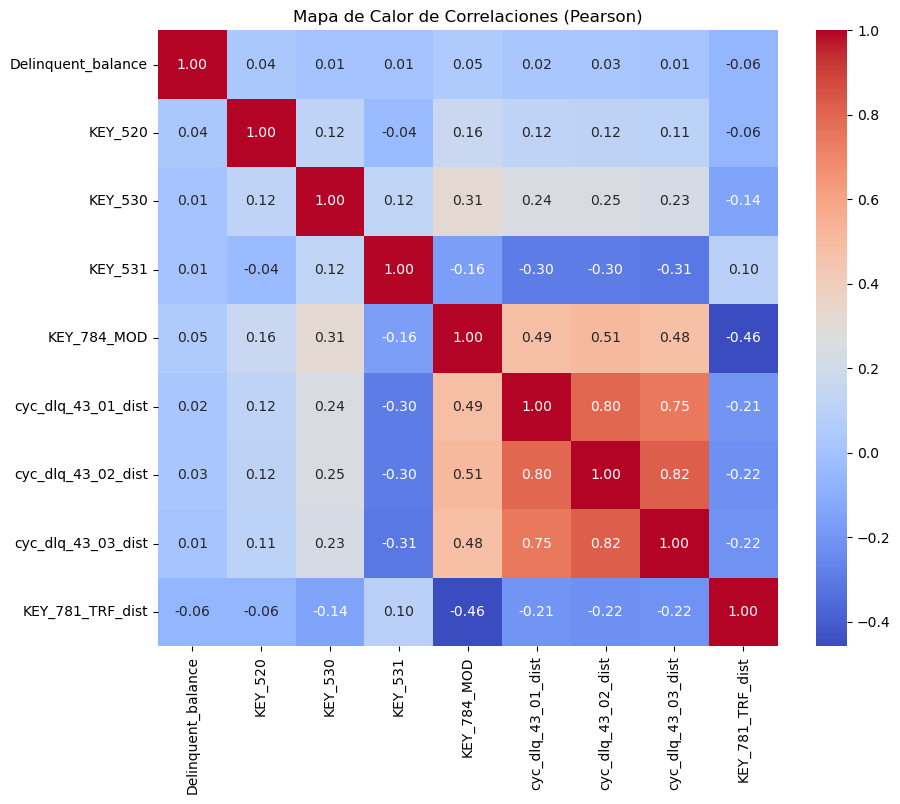

C:\Users\Fernando_Fuentes\AppData\Local\Temp\ipykernel_84888\3330844189.py:253: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
C:\Users\Fernando_Fuentes\AppData\Local\Temp\ipykernel_84888\3330844189.py:253: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
C:\Users\Fernando_Fuentes\AppData\Local\Temp\ipykernel_84888\3330844189.py:253: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

In [1171]:
resultados_relaciones = relaciones_entre_variables(datos_cobranza, listas_variables, max_categorias=10)


In [1173]:
print("Relaciones Lineales (Pearson):")
print(resultados_relaciones["relaciones_lineales"])

print("\nRelaciones No Lineales (Spearman):")
print(resultados_relaciones["relaciones_no_lineales"])

print("\nRelaciones con Variables Categóricas (Eta Squared):")
print(resultados_relaciones["relaciones_categoricas"])

Relaciones Lineales (Pearson):
[{'variables': ('cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist'), 'correlacion': 0.821160547267716}, {'variables': ('cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist'), 'correlacion': 0.7991379991719632}, {'variables': ('cyc_dlq_43_01_dist', 'cyc_dlq_43_03_dist'), 'correlacion': 0.7456754249425984}]

Relaciones No Lineales (Spearman):
[{'variables': ('cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist'), 'correlacion': 0.857769190874316}, {'variables': ('cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist'), 'correlacion': 0.8228120438834827}, {'variables': ('cyc_dlq_43_01_dist', 'cyc_dlq_43_03_dist'), 'correlacion': 0.7948824960294141}]

Relaciones con Variables Categóricas (Eta Squared):
[{'categoria': 'final_affluent_flag', 'numerica': 'Delinquent_balance', 'eta_squared': 0.02402651228736448}, {'categoria': 'LMT_flag', 'numerica': 'cyc_dlq_43_01_dist', 'eta_squared': 0.018740839118642303}, {'categoria': 'LMT_flag', 'numerica': 'cyc_dlq_43_02_dist', 'eta_squared': 0.017841013320625123}]

### Aplicación de K-Means

Calculando el Método del Codo...


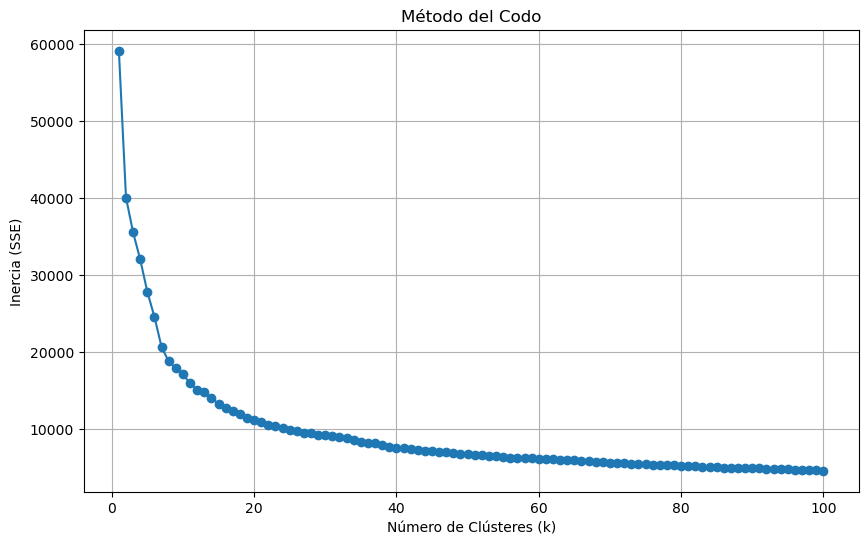

El número óptimo de clústeres según el Método del Codo es: 4
Calculando el Método de la Silueta...


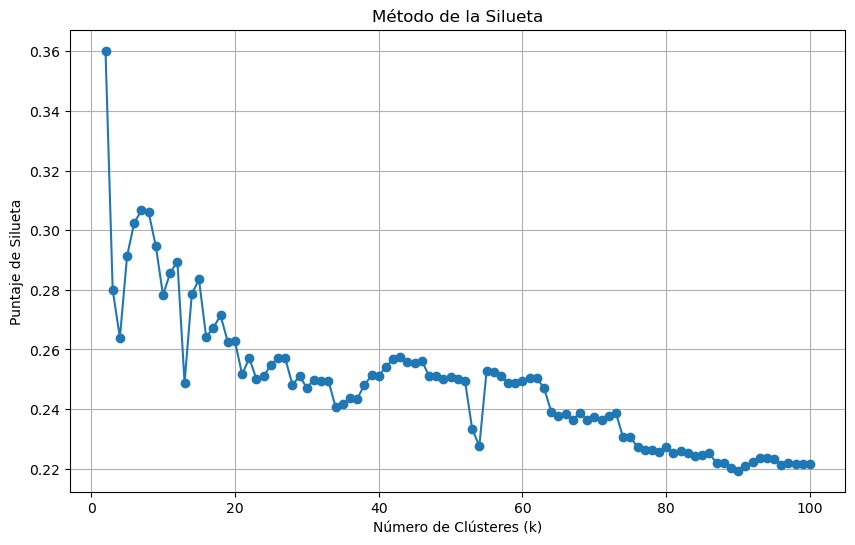

El número óptimo de clústeres según el Método de la Silueta es: 2
Calculando el Método de Gap Statistic...
El número óptimo de clústeres según el Método de Gap Statistic es: 1

Resumen:
- Método del Codo: 4
- Método de la Silueta: 2
- Gap Statistic: 1


In [1176]:
data = data = datos_cobranza[listas_variables["numericas"]]

#Normalizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Rango de k
k_range = range(1, 101)

# 1. Método del Codo
print("Calculando el Método del Codo...")
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

# Determinar el mejor k según el Método del Codo
codo_optimo = np.diff(inertia, 2).argmin() + 2
print(f"El número óptimo de clústeres según el Método del Codo es: {codo_optimo}")

# 2. Método de la Silueta
print("Calculando el Método de la Silueta...")
silhouette_scores = []
for k in k_range[1:]:  # Silueta no se define para k=1
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Graficar el Método de la Silueta
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Puntaje de Silueta')
plt.title('Método de la Silueta')
plt.grid(True)
plt.show()

# Determinar el mejor k según el Método de la Silueta
silueta_optima = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres según el Método de la Silueta es: {silueta_optima}")

# 3. Gap Statistic
print("Calculando el Método de Gap Statistic...")
optimalK = OptimalK(parallel_backend='joblib')  # Asegúrate de tener instalada la librería 'gap-statistic'
best_k_gap = optimalK(data_scaled, cluster_array=np.arange(1, 101))
print(f"El número óptimo de clústeres según el Método de Gap Statistic es: {best_k_gap}")

# Resultado Final
print("\nResumen:")
print(f"- Método del Codo: {codo_optimo}")
print(f"- Método de la Silueta: {silueta_optima}")
print(f"- Gap Statistic: {best_k_gap}")

In [1180]:
# Repetir K-Means 50 veces con k = 3 para obtener el mejor resultado
k = 3
n_repeats = 50
best_model = None
lowest_inertia = float('inf')

print(f"Ejecutando K-Means {n_repeats} veces para seleccionar el mejor resultado...")
for i in range(n_repeats):
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=i)  # Cambiar la semilla en cada iteración
    kmeans.fit(data_scaled)
    if kmeans.inertia_ < lowest_inertia:
        lowest_inertia = kmeans.inertia_
        best_model = kmeans

# Mejor modelo
labels = best_model.labels_

# Agregar etiquetas al DataFrame original
datos_cobranza['Cluster'] = labels

# Centroides del mejor modelo
centroids = best_model.cluster_centers_

print("\nResultados del Mejor K-Means:")
print(f"- Número de clústeres: {k}")
print(f"- Menor inercia (SSE): {lowest_inertia}")
print(f"- Etiquetas asignadas: {np.unique(labels)}")

# Centroides
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=data.columns)
print("\nCentroides de los clústeres:")
print(centroids_df)

Ejecutando K-Means 50 veces para seleccionar el mejor resultado...

Resultados del Mejor K-Means:
- Número de clústeres: 3
- Menor inercia (SSE): 35063.737153742404
- Etiquetas asignadas: [0 1 2]

Centroides de los clústeres:
   Delinquent_balance      KEY_520     KEY_530   KEY_531  KEY_784_MOD  \
0        15272.343468  1695.204054  231.408381  2.299096   767.351411   
1        13700.132164   353.525235  111.293841  4.379384   715.037639   
2         9880.697391   274.558261   86.266087  3.996522   674.271304   

   cyc_dlq_43_01_dist  cyc_dlq_43_02_dist  cyc_dlq_43_03_dist  \
0            0.603135            0.606868            0.605349   
1            0.126138            0.128707            0.181792   
2            0.228857            0.236892            0.282574   

   KEY_781_TRF_dist  
0          0.008729  
1          0.026408  
2          0.616899  


Aplicando PCA para K-Means...


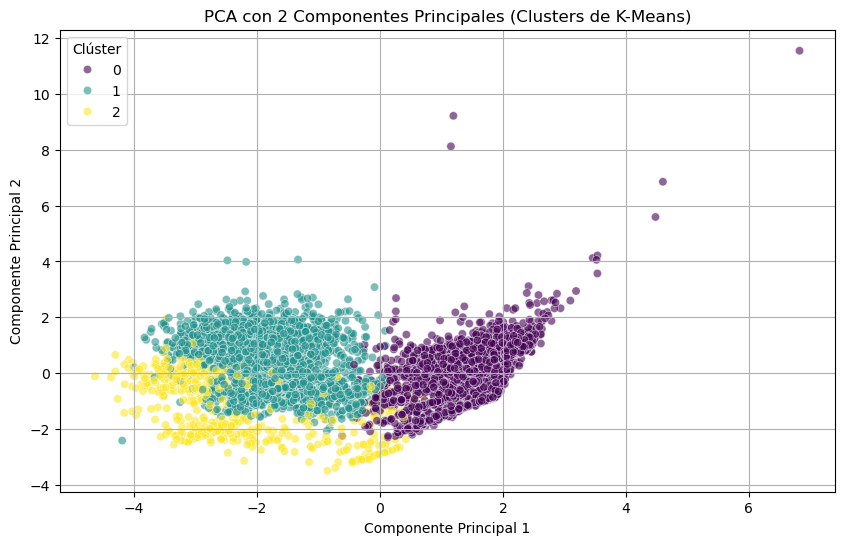

In [1182]:
# Aplicar PCA para reducir a 2 componentes principales
print("Aplicando PCA para K-Means...")
pca = PCA(n_components=2)
data_pca_kmeans = pca.fit_transform(data_scaled)

# Crear un DataFrame con las componentes principales y las etiquetas de K-Means
pca_kmeans_df = pd.DataFrame(data_pca_kmeans, columns=['Componente_1', 'Componente_2'])
pca_kmeans_df['Cluster'] = labels  # Etiquetas de K-Means

# Visualización de las dos primeras componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Componente_1',
    y='Componente_2',
    hue='Cluster',
    palette='viridis',
    data=pca_kmeans_df,
    alpha=0.6
)
plt.title("PCA con 2 Componentes Principales (Clusters de K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster", loc='best')
plt.grid(True)
plt.show()

C:\Users\Fernando_Fuentes\AppData\Local\Temp\ipykernel_84888\3791988225.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clúster", loc='best')


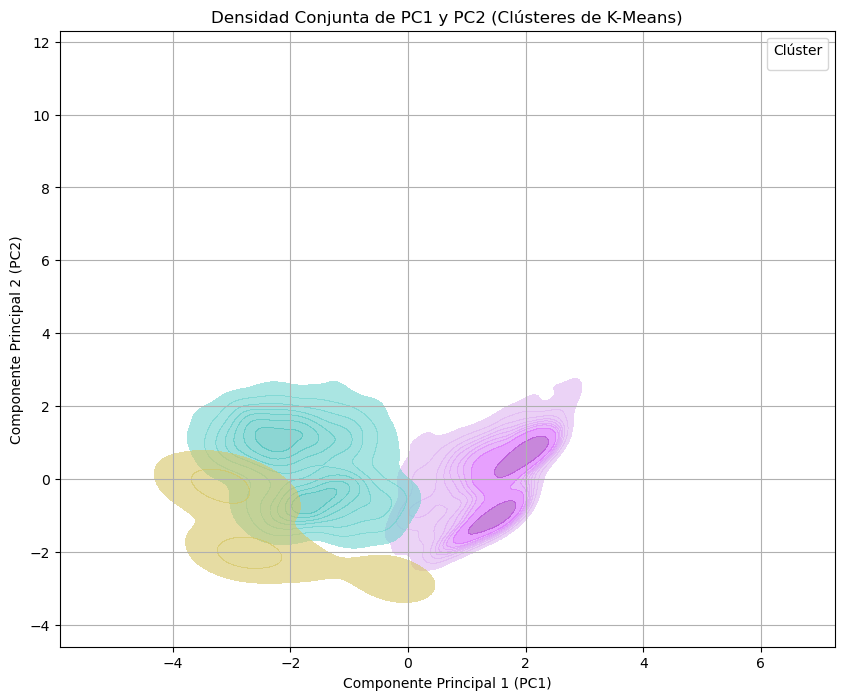

In [1184]:

# Gráfico de densidad conjunta para PC1 y PC2 coloreado por Clúster
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=pca_kmeans_df['Componente_1'], 
    y=pca_kmeans_df['Componente_2'], 
    hue=pca_kmeans_df['Cluster'], 
    fill=True, 
    palette='viridis', 
    alpha=0.6
)
plt.title("Densidad Conjunta de PC1 y PC2 (Clústeres de K-Means)")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.grid(True)
plt.legend(title="Clúster", loc='best')
plt.show()

In [1185]:
import skfuzzy as fuzzy
# Aplicar Fuzzy C-Means con skfuzzy
print("Aplicando Fuzzy C-Means...")

# Transponer los datos escalados para ajustarse al formato esperado por skfuzzy
data_t = data_scaled.T  # skfuzzy requiere variables como columnas

# Configurar y ejecutar Fuzzy C-Means
n_clusters = 3  # Número de clústeres
cntr, u, u0, d, jm, p, fpc = fuzzy.cmeans(
    data_t, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Obtener etiquetas de clúster basadas en la mayor pertenencia
fuzzy_labels = np.argmax(u, axis=0)
# Calcular Silhouette Score para Fuzzy C-Means
fuzzy_silhouette = silhouette_score(data_scaled, fuzzy_labels)

print("\nResultados de Fuzzy C-Means:")
print(f"- Coeficiente de Partición (FPC): {fpc:.2f}")
print(f"- Silhouette Score: {fuzzy_silhouette:.2f}")

Aplicando Fuzzy C-Means...

Resultados de Fuzzy C-Means:
- Coeficiente de Partición (FPC): 0.51
- Silhouette Score: 0.27


Aplicando PCA...


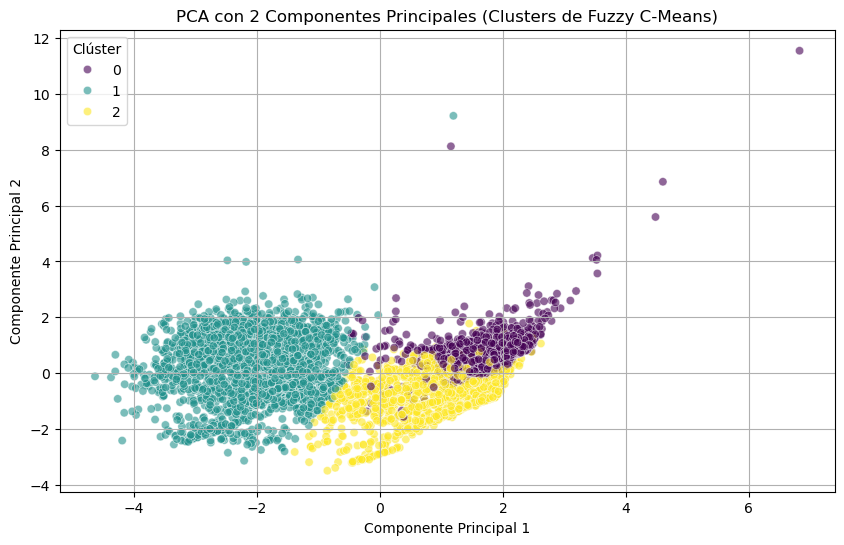

In [1186]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 componentes principales
print("Aplicando PCA...")
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Crear un DataFrame con las componentes principales y las etiquetas de Fuzzy C-Means
pca_df = pd.DataFrame(data_pca, columns=['Componente_1', 'Componente_2'])
pca_df['Cluster'] = fuzzy_labels

# Visualización de las dos primeras componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Componente_1',
    y='Componente_2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title("PCA con 2 Componentes Principales (Clusters de Fuzzy C-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster", loc='best')
plt.grid(True)
plt.show()
